In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from tabulate import tabulate

In [15]:
tickers = '^GSPC AAPL MSFT GOOGL AMZN TSLA NFLX META IBM UBER JPM C NVDA SMH PYPL INTU ADBE CRM ORCL NOW ADP SHOP SPOT'
data = yf.download(tickers, start='2015-01-01', end='2023-12-31')['Adj Close']

[*********************100%%**********************]  23 of 23 completed


In [16]:
correlation_matrix = data.corr()

# Identify highly correlated pairs (e.g., correlation > 0.8)
tickers_list = tickers.split()
highly_correlated_pairs = [(tickers_list[i], tickers_list[j]) for i in range(len(tickers_list)) for j in range(i+1, len(tickers_list)) if correlation_matrix.iloc[i, j] > 0.8]

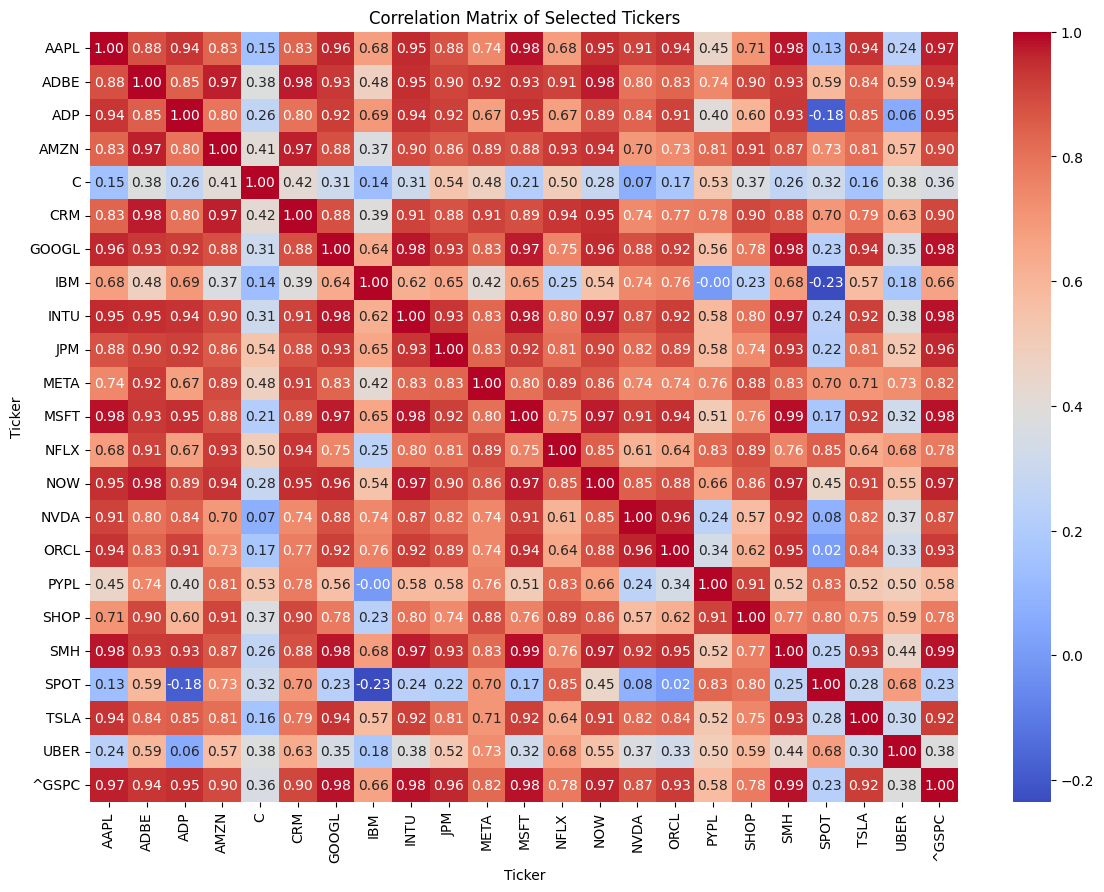

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Tickers')
plt.show()

In [18]:
def download_data(pair, start, end):
    asset1 = yf.download(pair[0], start=start, end=end)
    asset2 = yf.download(pair[1], start=start, end=end)
    return asset1, asset2

In [19]:
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [20]:
def calculate_strategy_returns(asset1_close, asset2_close, signal, trading_fee):
    returns1 = asset1_close.pct_change()
    returns2 = asset2_close.pct_change()
    spread_returns = signal.shift(1) * (returns1 - returns2) - trading_fee * abs(signal.diff())
    return spread_returns

In [21]:
def calculate_performance_metrics(strategy_returns):
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    annualized_return = strategy_returns.mean() * 252
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    return annualized_return, sharpe_ratio, cumulative_returns[-1], max_drawdown, cumulative_returns

In [22]:
def pairs_trade(pair, entry_threshold=70, exit_threshold=30, start='2020-01-01', end='2023-12-31'):
    asset1, asset2 = download_data(pair, start, end)
    asset1_close = asset1['Adj Close']
    asset2_close = asset2['Adj Close']

    spread = asset1_close - asset2_close
    rsi = calculate_rsi(spread)

    signal = pd.Series(index=spread.index, dtype=float)
    signal[rsi > entry_threshold] = -1  # Short the spread
    signal[rsi < exit_threshold] = 1   # Long the spread
    signal[rsi.between(exit_threshold, entry_threshold)] = 0  # Exit positions
    signal.ffill(inplace=True)

    trading_fee = 0.001
    net_strategy_returns = calculate_strategy_returns(asset1_close, asset2_close, signal, trading_fee)

    performance_metrics = calculate_performance_metrics(net_strategy_returns)

    # Calculate win rate and consistency ratio
    winning_trades = (net_strategy_returns > 0).sum()
    consistency_trades = ((net_strategy_returns > 0).cumsum() > 0).sum()

    win_rate = winning_trades / len(net_strategy_returns)
    consistency_ratio = consistency_trades / len(net_strategy_returns)

    return (pair, performance_metrics[2], performance_metrics[3], performance_metrics[1], win_rate, consistency_ratio, spread, signal, performance_metrics[4])

In [27]:
table_headers = ['Pair', 'Net Cumulative Return (%)', 'Maximum Drawdown', 'Sharpe Ratio', 'Win Rate', 'Consistency Ratio']
table_data = []

for result in results:
    table_data.append([result[0], f'{result[1]*100:.2f}%', f'{result[2]:.4f}', f'{result[3]:.4f}', f'{result[4]:.4f}', f'{result[5]:.4f}'])

# Print the table
print(tabulate(table_data, headers=table_headers, tablefmt='grid'))

+--------------------+-----------------------------+--------------------+----------------+------------+---------------------+
| Pair               | Net Cumulative Return (%)   |   Maximum Drawdown |   Sharpe Ratio |   Win Rate |   Consistency Ratio |
+====================+=============================+====================+================+============+=====================+
| ('^GSPC', 'AAPL')  | -10.31%                     |             0.1985 |        -0.2122 |     0.1113 |              0.9622 |
+--------------------+-----------------------------+--------------------+----------------+------------+---------------------+
| ('^GSPC', 'MSFT')  | -45.27%                     |             0.4618 |        -1.4501 |     0.1093 |              0.9692 |
+--------------------+-----------------------------+--------------------+----------------+------------+---------------------+
| ('^GSPC', 'GOOGL') | -49.06%                     |             0.5019 |        -1.515  |     0.0984 |              0

In [28]:
results = []
for pair in highly_correlated_pairs:
    result = pairs_trade(pair, entry_threshold=70, exit_threshold=30)
    results.append(result)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\abhir\AppData\Local\Temp\ipykernel_29208\4043883912.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return annualized_return, sharpe_ratio, cumulative_returns[-1], max_drawdown, cumulative_returns
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\abhir\AppData\Local\Temp\ipykernel_29208\4043883912.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return annualized_return,

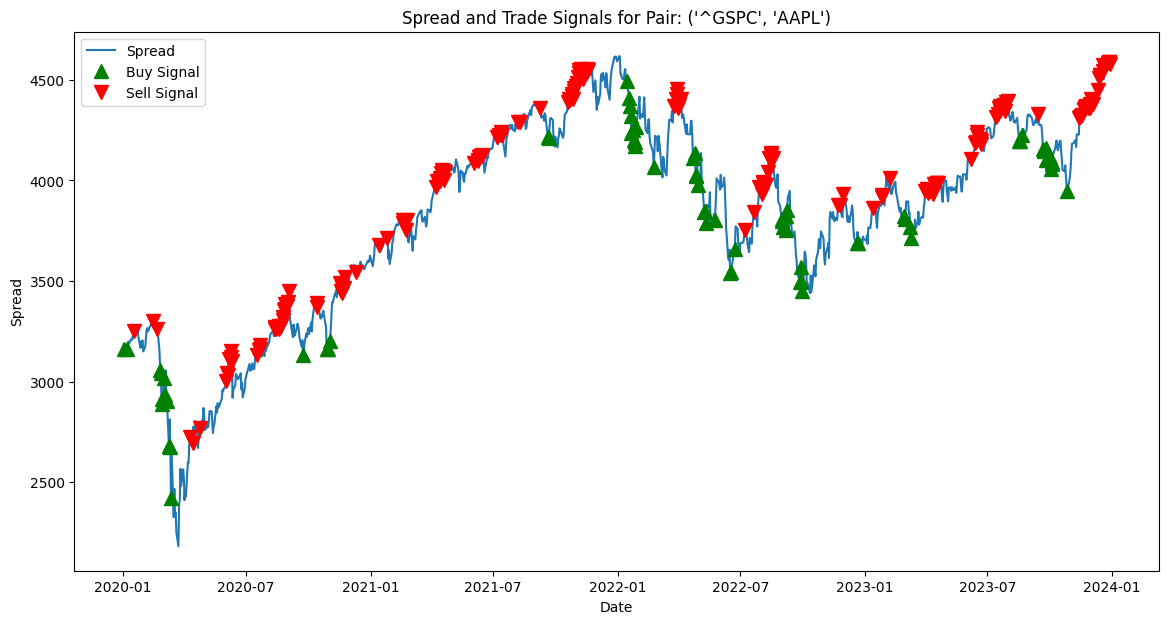

In [24]:
selected_pair = highly_correlated_pairs[0]  # Example: first pair in the list
pair_result = results[0]

# Plot spread and signals for the selected pair
spread = pair_result[6]
signal = pair_result[7]

plt.figure(figsize=(14, 7))
plt.plot(spread.index, spread, label='Spread')
plt.plot(spread[signal == 1].index, spread[signal == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(spread[signal == -1].index, spread[signal == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title(f'Spread and Trade Signals for Pair: {selected_pair}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

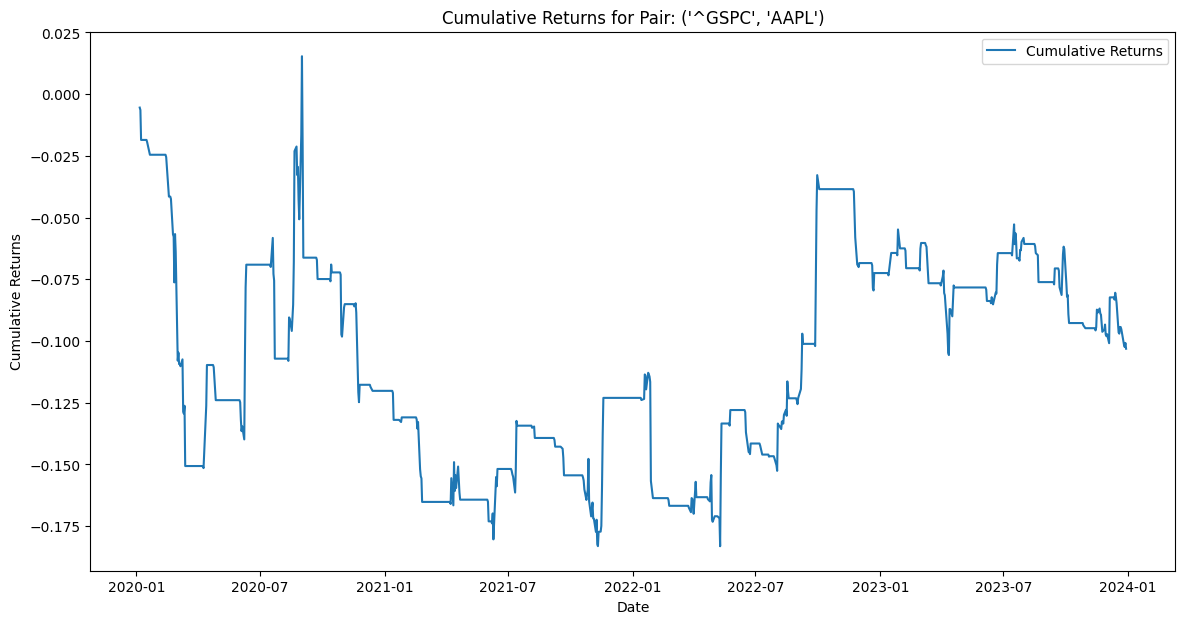

In [25]:
cumulative_returns = pair_result[8]

plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns')
plt.title(f'Cumulative Returns for Pair: {selected_pair}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()